## UART loopback verification

Setup for verification of a UART loopback on two levels:

* [After translation (to RTL)](#Testing)
* [After technology mapping](#Testing-technology-mapping)

This code is also making usage of external Verilog implementations of a portable and synthesizeable Block RAM.

In [1]:
import config

In [2]:
! rm -f *.vcd

## UART 'translator'

Instead of a direct loopback, we insert a somewhat more complex UART core and use some simple
translation by masking characters (type lower caps words into the console)

In [3]:
from myhdl import *
from cores.uart import uart_core, uart_WritePort, uart_ReadPort
from myhdl.conversion import yshelper
 
@block
def uart_translator(clk, reset, txd, rxd, DIV = 200):
    "Simple UART translation, direct hard loopthrough"
    rxready_d = Signal(bool())
    uart_idle = Signal(bool())
    uctrl = uart_WritePort("ctrl")
    ustat = uart_ReadPort("stat")
    rxirq = Signal(bool())    
    uart_data = Signal(intbv()[8:])
    state_t = enum("S_IDLE", "S_READ", "S_WAIT")
    inst_uart_loopback = uart_core(txd, rxd, rxirq, uctrl, ustat, clk)

    state = Signal(state_t.S_IDLE)
    
    @always_comb
    def assign():
        uctrl.uart_clkdiv.next = DIV
        uctrl.rx_irq_enable.next = False
        uctrl.uart_reset.next = reset

    @always(clk.posedge)
    def uart_lb_translate():
        "Loopback with some translation"
        uctrl.select_uart_txr.next = False
        uctrl.select_uart_rxr.next = False
        rxready_d.next = ustat.rxready
        if reset:
            state.next = state_t.S_IDLE
        else:                
            if state == state_t.S_IDLE:
                if ustat.rxready:
                    uart_data.next = ustat.rxdata
                    uctrl.select_uart_rxr.next = True  # trigger 'read'
                    state.next = state_t.S_READ      
            elif state == state_t.S_READ:
                if rxready_d:
                    if uart_data > 0x40 and uart_data < 0xff:
                        uctrl.uart_txr.next = uart_data & 0b01011111
                    else:
                        uctrl.uart_txr.next = uart_data
                    uctrl.select_uart_txr.next = True  #Trigger 'write'
                    state.next = state_t.S_WAIT     
            elif state == state_t.S_WAIT:
                if not rxready_d:
                    state.next = state_t.S_IDLE     

    return instances()

Then we create a synthesis design from it:

In [4]:
def convert():
    clk = Signal(bool())
    reset = ResetSignal(0, 1, False)

    txd, rxd = [ Signal(bool()) for i in range(2) ]
    
    lb = uart_translator(clk, reset, txd, rxd, DIV = 13)

    design = yshelper.Design("loopback")
    # Enable trace for VCD analysis of cosimulated module
    lb.convert("yosys_module", design, trace=True)

    return design

design = convert()

CREATE Module: 'counter_0'
Adding module with name: counter_1_1_1_3
CONVERT_RTL tree >>>>>> 'UART_TRANSLATOR_UART_CORE_0_UART_RX_0_COUNTER_0_WORKER' 
TRUNC: /home/pyosys/work/myhdl-synthesis/examples/cores/uart.py:29 Implicit carry truncate: bitcount[3:], src[4:]
DONE instancing submodules
CREATE Module: 'counter_1'
CREATE Module: 'bram_2psync_0'
	Infer blackbox: 'bram_2psync_0'
Adding module with name: bram_2psync_1
Non-Signal member a_in__name
Non-Signal member a_in__otype
Non-Signal member b_in__name
Non-Signal member b_in__otype
Non-Signal member a_out__name
Non-Signal member a_out__otype
Non-Signal member b_out__name
Non-Signal member b_out__otype
============ BULK COLLECT <a> for IdString "\bram_2psync_1" ============
============ BULK COLLECT <b> for IdString "\bram_2psync_1" ============
============ BULK COLLECT <a> for IdString "\bram_2psync_1" ============
============ BULK COLLECT <b> for IdString "\bram_2psync_1" ============
config param ADDR = 6
config param DATA = 8
Add

### RTL view of UART core

Generating RTL image...
Display...


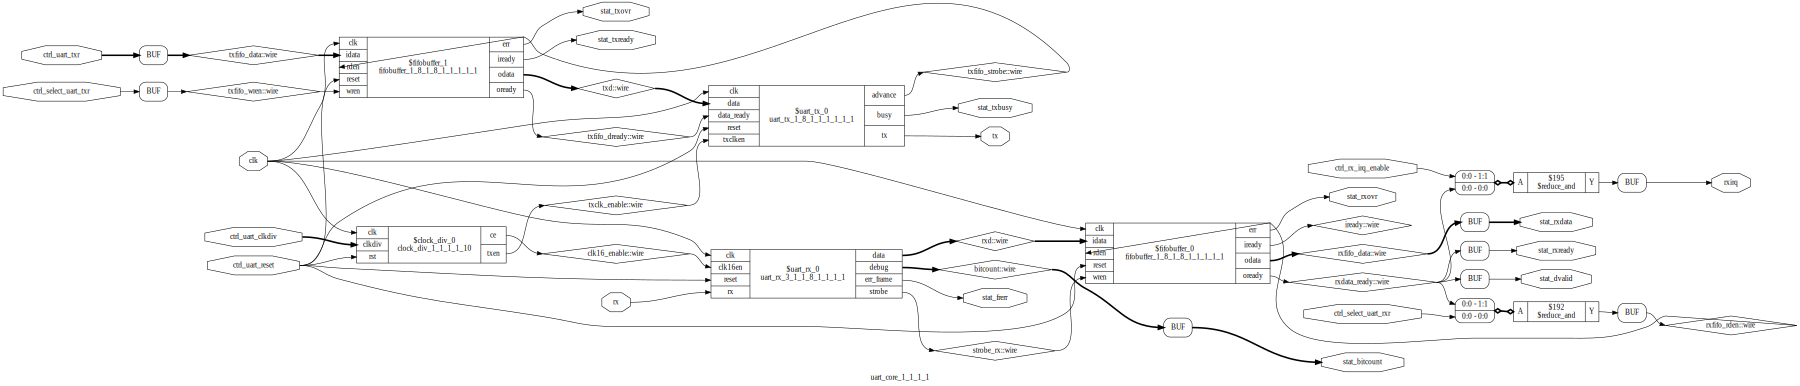

In [5]:
from ys_aux import *
to_svg(design, "uart_core_1_1_1_1", 400)

## Testing

### Testing the synthesis and black box

This method writes the synthesized design into a verilog file and resolves the black box `bram_2psync` during simulation time by just adding `bram.v` file to the simulated files.

In [6]:
design.write_verilog("uart_translator", rename_default=True, rename_signals=True)

Then we create a CoSimulation object, including the simulation for the `bram.v` blackbox:

In [7]:
from ys_aux import setupCosimulation

EXTRA_FILES = [config.MYHDL_SYNTHESIS_EXAMPLES + "verilog/bram.v"]

@block
def mapped_uart_translator(clk, reset, txd, rxd, DIV = 200):
    "Wrapper for cosimulation object"
    args = locals()
    name = "uart_translator_mapped"
    return setupCosimulation(name, use_assert=False, interface=args, debug=True, extra_files=EXTRA_FILES)

### Testbench

This is the virtual peer peripheral to the UART translator to send and receive values.
The string in the `word` variable is transmitted after startup.

In [8]:
word = b"zippengnaster"

UPERIOD = int(1e12 // 115200)

# Period for 25 MHz
CLKHALFPERIOD = 500000 // 25

from cores.uart import clock_div, uart_rx

@block
def uart_receiver(clk, reset, rxd, DIV=13):
    "Simple UART translation, direct hard loopthrough"
    strobe_rx = Signal(bool())
    bitcount = Signal(intbv()[3:])
    rxdata = Signal(intbv()[8:])
    uctrl = uart_WritePort("ctrl")
    ustat = uart_ReadPort("stat")
    txd, rxirq = [Signal(bool()) for i in range(2) ]

    clk16_enable, txclk_enable = [ Signal(bool()) for i in range(2) ]
    
    clkdiv_inst = clock_div(clk, uctrl.uart_reset, clk16_enable, \
        txclk_enable, uctrl.uart_clkdiv)
    
    rx_inst = uart_rx(bitcount, rxd, ustat.frerr, rxdata, strobe_rx, \
        uctrl.uart_reset, clk16_enable, clk)

    @always_comb
    def assign():
        uctrl.uart_clkdiv.next = DIV
        uctrl.rx_irq_enable.next = False
        uctrl.uart_reset.next = reset

    @always(strobe_rx.posedge)
    def poll():
        print("UART DATA: '%s'" % chr(rxdata))

    return instances()

@block
def tb_loopback(uut):
    clk = Signal(bool())
    reset = ResetSignal(0, 1, False)

    txd, rxd = [ Signal(bool()) for i in range(2) ]
    
    lb = uut(clk, reset, txd, rxd, DIV = 13)
    
    rcv = uart_receiver(clk, reset, txd)

    @always(delay(CLKHALFPERIOD))
    def clkgen():
        clk.next = not clk

    @instance
    def stim():
        reset.next = True
        rxd.next = True
        for _ in range(3):
            yield clk.posedge
        reset.next = False
        yield delay(UPERIOD)

        for c in word:
            rxd.next = False
            yield delay(UPERIOD)

            for i in range(8):
                rxd.next = c & 1
                yield delay(UPERIOD)
                c >>= 1
            rxd.next = True    
            yield delay(UPERIOD)

        for _ in range(3):         
            yield delay(10 * UPERIOD)
    
        raise StopSimulation()       

    return instances()


#### Run test bench

In [9]:
tb = tb_loopback(mapped_uart_translator)
tb.config_sim(name = "trace_syn", backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

Analyze command: iverilog -g2012 -o uart_translator_mapped.o uart_translator_mapped.v tb_uart_translator_mapped.v /home/pyosys/work/myhdl-synthesis/examples/verilog/bram.v
Simulation command: vvp -m /home/pyosys/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi uart_translator_mapped.o
UART DATA: 'Z'
UART DATA: 'I'
UART DATA: 'P'
UART DATA: 'P'
UART DATA: 'E'
UART DATA: 'N'
UART DATA: 'G'
UART DATA: 'N'
UART DATA: 'A'
UART DATA: 'S'
UART DATA: 'T'
UART DATA: 'E'
UART DATA: 'R'


### Examining the trace

Two VCD files were generated:

1. The top level test bench `tb_loopback`: [trace_syn.vcd](trace_syn.vcd)
2. The Trace from the iverilog cosimulation [uart_translator.vcd](uart_translator.vcd)

Download these traces and display them locally using GTKwave.

To verify these files were created:

In [10]:
! ls *.vcd

trace_syn.vcd  uart_translator.vcd


## Testing technology mapping

We synthesize the above design, but include the bram.v code first, **then** synthesize and map into ECP5
specific primitives. From this mapped object, we create a cosimulation object to simulate against. This simulation might run slow, but it is verifying the correct behaviour on the primitive (close to gate) level.

In [11]:
from ecp5aux import synthesize, simulation_files

EXTRA_FILES = simulation_files[:]
EXTRA_FILES += ['-I', '/usr/share/yosys/ecp5/' ]

design = convert()
design.import_verilog(config.MYHDL_SYNTHESIS_EXAMPLES + "verilog/bram.v")

design.run("hierarchy -check")  # important to resolve
synthesize(design)
    
design.write_verilog("uart_translator", rename_default=True, rename_signals=True)
# design.write_ilang("uart_translator")

CREATE Module: 'counter_1_0'
Adding module with name: counter_1_1_1_3
CONVERT_RTL tree >>>>>> 'UART_TRANSLATOR_UART_CORE_0_0_UART_RX_1_0_COUNTER_1_0_WORKER' 
TRUNC: /home/pyosys/work/myhdl-synthesis/examples/cores/uart.py:29 Implicit carry truncate: bitcount[3:], src[4:]
DONE instancing submodules
CREATE Module: 'counter_2_0'
CREATE Module: 'bram_2psync_0_0'
	Infer blackbox: 'bram_2psync_0_0'
Adding module with name: bram_2psync_1
Non-Signal member a_in__name
Non-Signal member a_in__otype
Non-Signal member b_in__name
Non-Signal member b_in__otype
Non-Signal member a_out__name
Non-Signal member a_out__otype
Non-Signal member b_out__name
Non-Signal member b_out__otype
============ BULK COLLECT <a> for IdString "\bram_2psync_1" ============
============ BULK COLLECT <b> for IdString "\bram_2psync_1" ============
============ BULK COLLECT <a> for IdString "\bram_2psync_1" ============
============ BULK COLLECT <b> for IdString "\bram_2psync_1" ============
config param ADDR = 6
config para

### Verilog Co-Simulation object

In [12]:
from ys_aux import setupCosimulation

@block
def mapped_uart_translator(clk, reset, txd, rxd, DIV = 200):
    "Wrapper for cosimulation object"
    args = locals()
    name = "uart_translator_mapped"
    return setupCosimulation(name, use_assert=False, interface=args, debug=True, extra_files=EXTRA_FILES)

We run the test bench again, this time using the technology mapped cosimulation model.
This may run much slower. 
### Next: [Automated testing](autotest.ipynb)

In [13]:
tb = tb_loopback(mapped_uart_translator)
tb.config_sim(name = "trace_map", backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

Analyze command: iverilog -g2012 -o uart_translator_mapped.o uart_translator_mapped.v tb_uart_translator_mapped.v /usr/share/yosys/ecp5/cells_sim.v /usr/share/yosys/ecp5/cells_bb.v -I /usr/share/yosys/ecp5/
Simulation command: vvp -m /home/pyosys/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi uart_translator_mapped.o
UART DATA: 'Z'
UART DATA: 'I'
UART DATA: 'P'
UART DATA: 'P'
UART DATA: 'E'
UART DATA: 'N'
UART DATA: 'G'
UART DATA: 'N'
UART DATA: 'A'
UART DATA: 'S'
UART DATA: 'T'
UART DATA: 'E'
UART DATA: 'R'
